# Exploratory Data Analysis (EDA) on Cleaned Online Retail Data

This notebook performs EDA on the cleaned data stored on Azure Blob Storage. We will:
- Load the cleaned data from Azure using PySpark.
- Inspect the schema and view sample records.
- Compute basic descriptive statistics.
- Evaluate missing values.
- Visualize key distributions (e.g., Quantity, UnitPrice) and time-based trends.


In [22]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, year, month, dayofweek, hour
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load environment variables (ensure AZURE_STORAGE_KEY is set in your .env file)
load_dotenv()

# Set Azure Storage account details
account_name = "dataintensiveproject"
account_key = os.getenv("AZURE_STORAGE_KEY")
if not account_key:
    raise ValueError("AZURE_STORAGE_KEY environment variable not set.")

# Initialize Spark Session with Azure Blob Storage config
spark = SparkSession.builder \
    .appName("CleanedDataEDA") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.1,com.microsoft.azure:azure-storage:8.6.6") \
    .config(f"fs.azure.account.key.{account_name}.blob.core.windows.net", account_key) \
    .getOrCreate()

print("Spark Session created.")

Python-dotenv could not parse statement starting at line 2
Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 4


Spark Session created.


In [7]:
# Define input path for cleaned data (note: no .parquet suffix because Spark writes a folder)
cleaned_data_path = f"wasbs://retail-data@{account_name}.blob.core.windows.net/clean/retail_cleaned"

# Read the cleaned data
df_clean = spark.read.parquet(cleaned_data_path)

# Display the schema and a few sample rows
df_clean.printSchema()
df_clean.show(10, truncate=False)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp_ntz (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceYear: integer (nullable = true)
 |-- InvoiceMonth: integer (nullable = true)
 |-- InvoiceWeekday: integer (nullable = true)
 |-- InvoiceHour: integer (nullable = true)



+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-----------+------------+--------------+-----------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |InvoiceYear|InvoiceMonth|InvoiceWeekday|InvoiceHour|
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-----------+------------+--------------+-----------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|2010       |12          |4             |8          |
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|2010       |12          |4             |8          |
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |2010-12-01 08:26:00|2.75     |17850.0   |United Kingdom|201

In [8]:
# Count total records
total_records = df_clean.count()
print("Total records:", total_records)

# Use the describe method for numeric columns (for others, adjust as needed)
df_clean.describe().show()

# You can also compute summary statistics for specific columns, for example:
df_clean.groupBy("InvoiceYear").count().orderBy("InvoiceYear").show()


25/04/16 18:04:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Total records: 397884


+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------+-------------------+------------------+------------------+------------------+
|summary|        InvoiceNo|         StockCode|         Description|          Quantity|         UnitPrice|        CustomerID|    Country|        InvoiceYear|      InvoiceMonth|    InvoiceWeekday|       InvoiceHour|
+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------+-------------------+------------------+------------------+------------------+
|  count|           397884|            397884|              397884|            397884|            397884|            397884|     397884|             397884|            397884|            397884|            397884|
|   mean|560616.9344507444|27420.411850034085|                null|12.988237777844798| 3.116487755220217|15294.423452564064|       null| 2010.93

+-----------+------+
|InvoiceYear| count|
+-----------+------+
|       2010| 26157|
|       2011|371727|
+-----------+------+



In [10]:
# Count missing values in each column using isNull
missing_counts = df_clean.select([count(when(col(c).isNull(), c)).alias(c) for c in df_clean.columns])
missing_counts.show()

# Calculate the percentage of missing values for each column
total = df_clean.count()
missing_percent = missing_counts.select([ (col(c) / total * 100).alias(c + "_pct") for c in missing_counts.columns])
missing_percent.show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+------------+--------------+-----------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|InvoiceYear|InvoiceMonth|InvoiceWeekday|InvoiceHour|
+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+------------+--------------+-----------+
|        0|        0|          0|       0|          0|        0|         0|      0|          0|           0|             0|          0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+------------+--------------+-----------+



+-------------+-------------+---------------+------------+---------------+-------------+--------------+-----------+---------------+----------------+------------------+---------------+
|InvoiceNo_pct|StockCode_pct|Description_pct|Quantity_pct|InvoiceDate_pct|UnitPrice_pct|CustomerID_pct|Country_pct|InvoiceYear_pct|InvoiceMonth_pct|InvoiceWeekday_pct|InvoiceHour_pct|
+-------------+-------------+---------------+------------+---------------+-------------+--------------+-----------+---------------+----------------+------------------+---------------+
|          0.0|          0.0|            0.0|         0.0|            0.0|          0.0|           0.0|        0.0|            0.0|             0.0|               0.0|            0.0|
+-------------+-------------+---------------+------------+---------------+-------------+--------------+-----------+---------------+----------------+------------------+---------------+



In [25]:
from pyspark.sql.functions import date_format
import pandas as pd

# 1) Create a string column for InvoiceDate
df_with_date_str = df_clean.withColumn(
    "InvoiceDate_str",
    date_format("InvoiceDate", "yyyy-MM-dd HH:mm:ss").cast("string")
)

# 2) Drop the original TIMESTAMP column to avoid unit‐less datetime issues
df_for_pdf = df_with_date_str.drop("InvoiceDate")

# 3) Sample 10% and convert to Pandas
pdf = df_for_pdf.sample(False, 0.1).toPandas()

# 4) Parse the string into a proper datetime64[ns] dtype
pdf['InvoiceDate_str'] = pd.to_datetime(
    pdf['InvoiceDate_str'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

# 5) Check the result
print(pdf.head())
print(pdf.dtypes['InvoiceDate_str'])


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
1    536367     22310              IVORY KNITTED MUG COSY          6   
2    536367     84969   BOX OF 6 ASSORTED COLOUR TEASPOONS         6   
3    536367     21754             HOME BUILDING BLOCK WORD         3   
4    536368     22960             JAM MAKING SET WITH JARS         6   

   UnitPrice  CustomerID         Country  InvoiceYear  InvoiceMonth  \
0       3.39     17850.0  United Kingdom         2010            12   
1       1.65     13047.0  United Kingdom         2010            12   
2       4.25     13047.0  United Kingdom         2010            12   
3       5.95     13047.0  United Kingdom         2010            12   
4       4.25     13047.0  United Kingdom         2010            12   

   InvoiceWeekday  InvoiceHour     InvoiceDate_str  
0               4            8 2010-12-01 08:26:00  
1               4            8 201

In [27]:
# 1. Print Pandas dtypes for each column
print(pdf.dtypes)

# 2. (Optional) Get the actual Python type of the first value in each column
first_row = pdf.iloc[0]
for col in pdf.columns:
    print(f"{col!r}: {type(first_row[col])}")


InvoiceNo                  object
StockCode                  object
Description                object
Quantity                    int64
UnitPrice                 float64
CustomerID                float64
Country                    object
InvoiceYear                 int32
InvoiceMonth                int32
InvoiceWeekday              int32
InvoiceHour                 int32
InvoiceDate_str    datetime64[ns]
dtype: object
'InvoiceNo': <class 'str'>
'StockCode': <class 'str'>
'Description': <class 'str'>
'Quantity': <class 'numpy.int64'>
'UnitPrice': <class 'numpy.float64'>
'CustomerID': <class 'numpy.float64'>
'Country': <class 'str'>
'InvoiceYear': <class 'numpy.int32'>
'InvoiceMonth': <class 'numpy.int32'>
'InvoiceWeekday': <class 'numpy.int32'>
'InvoiceHour': <class 'numpy.int32'>
'InvoiceDate_str': <class 'pandas._libs.tslibs.timestamps.Timestamp'>


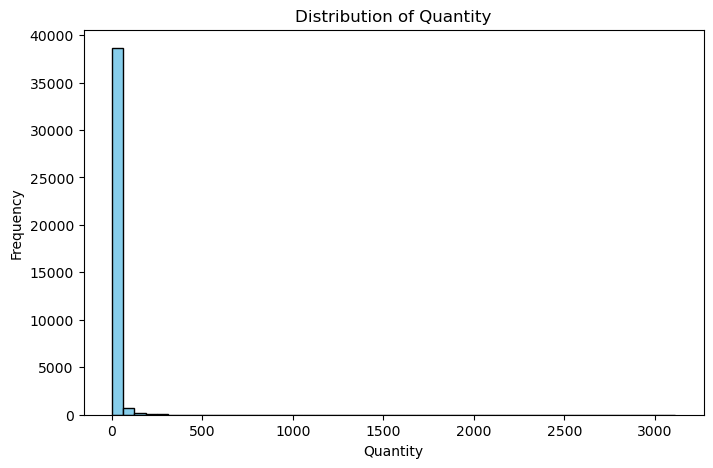

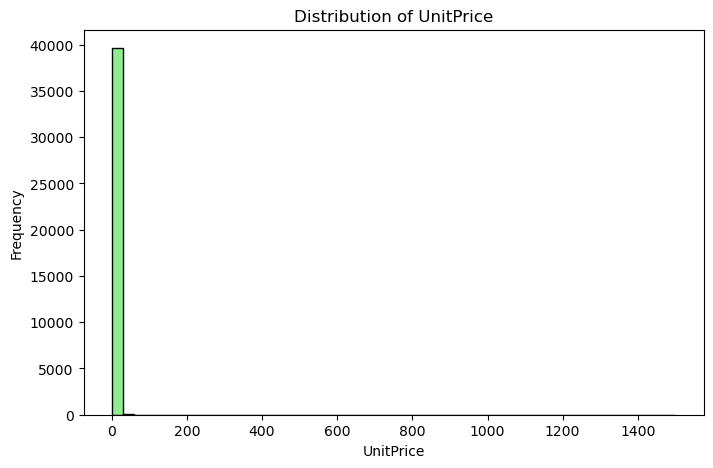

In [28]:
import matplotlib.pyplot as plt

# Histogram for Quantity
plt.figure(figsize=(8, 5))
plt.hist(pdf['Quantity'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.title("Distribution of Quantity")
plt.show()

# Histogram for UnitPrice
plt.figure(figsize=(8, 5))
plt.hist(pdf['UnitPrice'], bins=50, color='lightgreen', edgecolor='black')
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")
plt.title("Distribution of UnitPrice")
plt.show()


+-----------+------------+-----+
|InvoiceYear|InvoiceMonth|count|
+-----------+------------+-----+
|       2010|          12|26157|
|       2011|           1|21229|
|       2011|           2|19927|
|       2011|           3|27175|
|       2011|           4|22642|
|       2011|           5|28320|
|       2011|           6|27185|
|       2011|           7|26825|
|       2011|           8|27007|
|       2011|           9|40028|
|       2011|          10|49554|
|       2011|          11|64531|
|       2011|          12|17304|
+-----------+------------+-----+



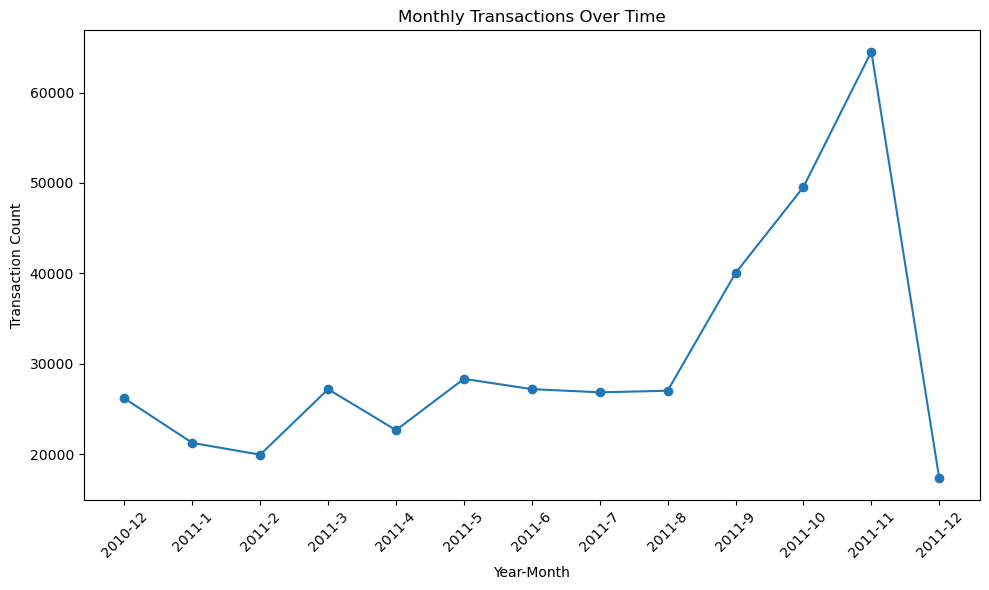

25/04/16 20:30:20 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 840189 ms exceeds timeout 120000 ms
25/04/16 20:30:20 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/16 20:30:25 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [ ]:
# Group by InvoiceYear and InvoiceMonth to see trends (aggregating count of transactions)
time_trends = df_clean.groupBy("InvoiceYear", "InvoiceMonth").count().orderBy("InvoiceYear", "InvoiceMonth")
time_trends.show()

# Convert to Pandas for line plot
time_trends_pdf = time_trends.toPandas()
time_trends_pdf['InvoiceMonth'] = time_trends_pdf['InvoiceMonth'].astype(int)
time_trends_pdf['InvoiceYear'] = time_trends_pdf['InvoiceYear'].astype(int)
time_trends_pdf = time_trends_pdf.sort_values(by=['InvoiceYear','InvoiceMonth'])

plt.figure(figsize=(10, 6))
plt.plot(time_trends_pdf['InvoiceYear'].astype(str) + "-" + time_trends_pdf['InvoiceMonth'].astype(str), time_trends_pdf['count'], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Transaction Count")
plt.title("Monthly Transactions Over Time")
plt.tight_layout()
plt.show()
